In [4]:
from qiskit import QuantumCircuit, transpile

from qiskit.quantum_info import SparsePauliOp
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLS import getApproximationValue, plotCost, minimization, getMatrixCoeffitients, ansatzTest, minimizationOld
from LSSVM import predict, lssvmMatrix, prepareLabels, accuracy

In [2]:
auxiliaryQubit = 0
shots = 10000 # 100000
gamma = 0.01 # regularization parameter
testSize = 0.2

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.04501022e+02  2.37033301e+00  4.48321092e-01
  -6.85705572e-01 -5.82458282e+00  7.79837350e+00  1.63360629e-01]
 [ 1.00000000e+00  2.37033301e+00  1.01256212e+02  3.86776044e-01
  -2.25150494e-01 -3.05246385e+00  4.09585027e+00  2.38909500e-01]
 [ 1.00000000e+00  4.48321092e-01  3.86776044e-01  1.02902670e+02
   2.51043769e+00 -2.97836388e-01  5.69291022e-01  2.91600852e+00]
 [ 1.00000000e+00 -6.85705572e-01 -2.25150494e-01  2.51043769e+00
   1.02431212e+02  1.14207243e+00 -1.37522665e+00  2.59149444e+00]
 [ 1.00000000e+00 -5.82458282e+00 -3.05246385e+00 -2.97836388e-01
   1.14207243e+00  1.07565235e+02 -1.01120401e+01  7.50402435e-02]
 [ 1.00000000e+00  7.79837350e+00  4.09585027e+00  5.69291022e-01
  -1.37522665e+00 -1.01120401e+01  1.13526354e+02  7.25461246e-02]
 [ 1.00000000e+00  1.63360629e-01  2.38909500e-01  2.9

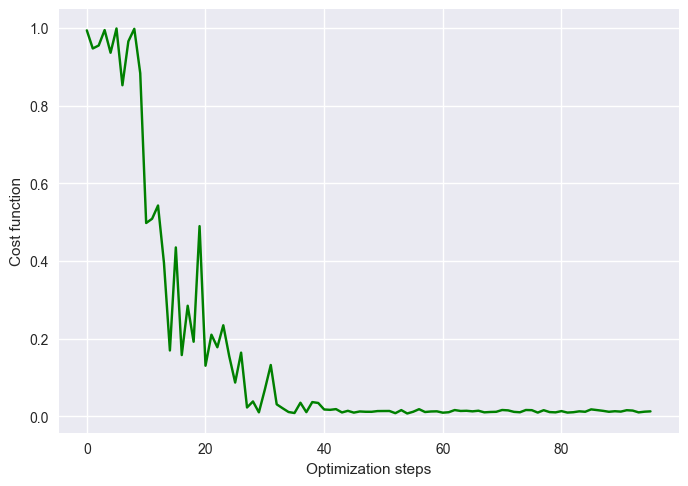

In [17]:
X, y = datasets.make_classification(
    n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetSize = 7
subsetIndices = np.random.choice(np.arange(X_train.shape[0]), subsetSize, replace=False)
xSubset = np.array([X_train[i] for i in subsetIndices])
ySubset = np.array([y_train[i] for i in subsetIndices])

inputMatrix = lssvmMatrix(xSubset, gamma, "linearKernel")
yVector = prepareLabels(ySubset)

print("LS-SVM Matrix:", inputMatrix)

pauliOp = SparsePauliOp.from_operator(inputMatrix)
paulis = pauliOp.paulis
print(paulis)

coefficientSet = getMatrixCoeffitients(pauliOp)
print(coefficientSet)

outF = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=yVector,
    quantumSimulation=True,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

getApproximationValue(inputMatrix, yVector, o)
plotCost()

Statevector([ 0.22760912+0.j,  0.27081126+0.j,  0.01357184+0.j,
             -0.56738119+0.j, -0.04156481+0.j, -0.47448844+0.j,
              0.00428777+0.j,  0.57084538+0.j],
            dims=(2, 2, 2))
[ -0.22391819+0.j  31.22435308+0.j   3.63596471+0.j -56.32676539+0.j
  -4.71150683+0.j -52.30864605+0.j   7.45547379+0.j  57.24498209+0.j]


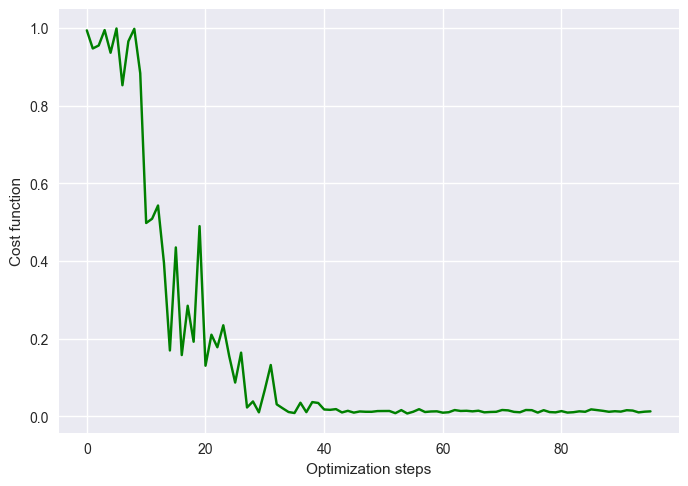

In [20]:
print(o)
print(inputMatrix.dot(o))

getApproximationValue(inputMatrix, yVector, o)
plotCost()

In [33]:
subsetIndicesTest = np.random.choice(
    np.arange(X_test.shape[0]), subsetSize, replace=False
)
xTestSubset = []
yTestSubset = []
for i in subsetIndicesTest:
    xTestSubset.append(X_test[i])
    yTestSubset.append(y_test[i])

xTestSubset = np.array(xTestSubset)
yTestSubset = np.array(yTestSubset)
print(o)
b = o[0]
print(b)
w = []
for i in range(len(o)):
    if i != 0:
        w.append(o[i])
print(w)
predictions = predict(xSubset, xTestSubset, w, b)
print("Predictions:", predictions)
print("Accuracy:", accuracy(yTestSubset, predictions))

Statevector([ 0.22760912+0.j,  0.27081126+0.j,  0.01357184+0.j,
             -0.56738119+0.j, -0.04156481+0.j, -0.47448844+0.j,
              0.00428777+0.j,  0.57084538+0.j],
            dims=(2, 2, 2))
(0.227609115+0j)
[(0.2708112611+0j), (0.0135718351+0j), (-0.567381187+0j), (-0.0415648128+0j), (-0.4744884353+0j), (0.0042877654+0j), (0.5708453834+0j)]
Predictions: [ 1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j]
Accuracy: 0.5714285714285714


LS-SVM Matrix: [[  0.           1.           1.           1.           1.
    1.           1.           1.        ]
 [  1.         101.25406524  -1.41354766  -0.49523748   1.25499132
   -0.79813188   0.91318628   1.24029987]
 [  1.          -1.41354766 102.18062811   1.6748155   -1.42772108
    0.79133818   0.45159469  -1.46146094]
 [  1.          -0.49523748   1.6748155  102.31843169  -0.52056495
    0.10929976   2.4548687   -0.61039222]
 [  1.           1.25499132  -1.42772108  -0.52056495 101.25621159
   -0.79630033   0.88075452   1.24263375]
 [  1.          -0.79813188   0.79133818   0.10929976  -0.79630033
  100.52792772  -0.85424675  -0.77767552]
 [  1.           0.91318628   0.45159469   2.4548687    0.88075452
   -0.85424675 104.39907431   0.74322633]
 [  1.           1.24029987  -1.46146094  -0.61039222   1.24263375
   -0.77767552   0.74322633 101.23353585]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY',

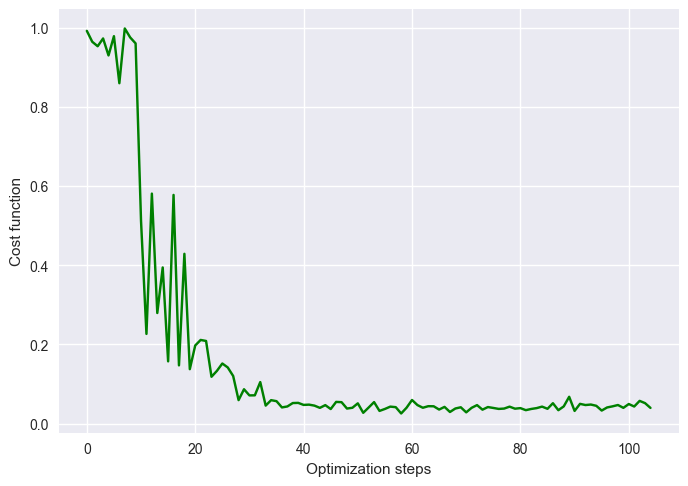

In [34]:
X, y = datasets.make_classification(
    n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetSize = 7
subsetIndices = np.random.choice(np.arange(X_train.shape[0]), subsetSize, replace=False)
xSubset = np.array([X_train[i] for i in subsetIndices])
ySubset = np.array([y_train[i] for i in subsetIndices])

inputMatrix = lssvmMatrix(xSubset, gamma, "linearKernel")
yVector = prepareLabels(ySubset)

print("LS-SVM Matrix:", inputMatrix)

pauliOp = SparsePauliOp.from_operator(inputMatrix)
paulis = pauliOp.paulis
print(paulis)

coefficientSet = getMatrixCoeffitients(pauliOp)
print(coefficientSet)

outF = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=yVector,
    quantumSimulation=True,
    shots = shots
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

getApproximationValue(inputMatrix, yVector, o)
plotCost()

In [3]:
X, y = datasets.make_classification(
    n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetSize = 7
subsetIndices = np.random.choice(np.arange(X_train.shape[0]), subsetSize, replace=False)
xSubset = np.array([X_train[i] for i in subsetIndices])
ySubset = np.array([y_train[i] for i in subsetIndices])

inputMatrix = lssvmMatrix(xSubset, gamma, "linearKernel")
yVector = prepareLabels(ySubset)

print("LS-SVM Matrix:", inputMatrix)

pauliOp = SparsePauliOp.from_operator(inputMatrix)
paulis = pauliOp.paulis
print(paulis)

coefficientSet = getMatrixCoeffitients(pauliOp)
print(coefficientSet)

outF = minimizationOld(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=yVector,
    quantumSimulation=False,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

getApproximationValue(inputMatrix, yVector, o)
plotCost()

LS-SVM Matrix: [[  0.           1.           1.           1.           1.
    1.           1.           1.        ]
 [  1.         101.60111111  -1.34621187  -1.61815653  -1.53312282
    1.44401806   1.47743785   3.24203541]
 [  1.          -1.34621187 101.23353585   1.51661117   0.74322633
   -1.31718883  -1.35511754  -3.04480074]
 [  1.          -1.61815653   1.51661117 101.87501726   0.7113636
   -1.61763539  -1.66650351  -3.76620828]
 [  1.          -1.53312282   0.74322633   0.7113636  104.39907431
   -0.82926639  -0.80848332  -1.39186754]
 [  1.           1.44401806  -1.31718883  -1.61763539  -0.82926639
  101.40683623   1.44694353   3.24729313]
 [  1.           1.47743785  -1.35511754  -1.66650351  -0.80848332
    1.44694353 101.48869896   3.34580323]
 [  1.           3.24203541  -3.04480074  -3.76620828  -1.39186754
    3.24729313   3.34580323 107.56523505]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 

NameError: name 'minimizationOld' is not defined

LS-SVM Matrix: [[  0.           1.           1.           1.           1.
    1.           1.           1.        ]
 [  1.         104.32024756   0.72328478  -0.44092196  -1.26795113
    2.08595844   0.11167467  -2.13686685]
 [  1.           0.72328478 102.90267026  -3.29038721  -3.58992127
    2.25903726   3.51560157   0.38677604]
 [  1.          -0.44092196  -3.29038721 103.76458341   4.03525373
   -2.42136355  -4.05515628  -0.64286781]
 [  1.          -1.26795113  -3.58992127   4.03525373 104.47357052
   -2.93127343  -4.2790321   -0.27691906]
 [  1.           2.08595844   2.25903726  -2.42136355  -2.93127343
  102.31843169   2.4548687   -0.52056495]
 [  1.           0.11167467   3.51560157  -4.05515628  -4.2790321
    2.4548687  104.39907431   0.88075452]
 [  1.          -2.13686685   0.38677604  -0.64286781  -0.27691906
   -0.52056495   0.88075452 101.25621159]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 

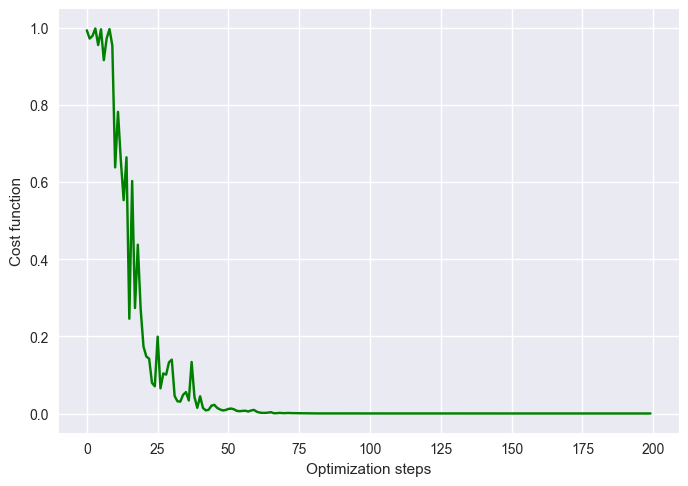

In [35]:
X, y = datasets.make_classification(
    n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetSize = 7
subsetIndices = np.random.choice(np.arange(X_train.shape[0]), subsetSize, replace=False)
xSubset = np.array([X_train[i] for i in subsetIndices])
ySubset = np.array([y_train[i] for i in subsetIndices])

inputMatrix = lssvmMatrix(xSubset, gamma, "linearKernel")
yVector = prepareLabels(ySubset)

print("LS-SVM Matrix:", inputMatrix)

pauliOp = SparsePauliOp.from_operator(inputMatrix)
paulis = pauliOp.paulis
print(paulis)

coefficientSet = getMatrixCoeffitients(pauliOp)
print(coefficientSet)

outF = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    totalNeededQubits=pauliOp.num_qubits + 2,
    bVector=yVector,
    quantumSimulation=False,
)
circ = QuantumCircuit(pauliOp.num_qubits, pauliOp.num_qubits)
o = ansatzTest(circ, outF)

getApproximationValue(inputMatrix, yVector, o)
plotCost()